# Transformers: Attention from Scratch

This is the heart of the Transformer (and GPT, and BERT).
We are going to implement **Scaled Dot-Product Attention** using only Linear Algebra.

### The Equation
$$ Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V $$

### The Intuition (The Dictionary)
Imagine a Python Dictionary `d = {'apple': 'red', 'banana': 'yellow'}`.
- **Query (Q):** What you look for (`'apple'`).
- **Key (K):** What the dictionary has (`'apple'`, `'banana'`).
- **Value (V):** The result (`'red'`, `'yellow'`).

In Neural Networks, the match is **Fuzzy**. You don't get 100% 'red'. You get 90% 'red' and 10% 'yellow' if your query is partially similar to both.

In [1]:
import torch
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import seaborn as sns

## 1. The Input (Embeddings)
Let's say we have 4 words. Each word is a vector of size 8 ($d_{model} = 8$).
In a real model, these come from an Embedding Layer.

In [2]:
torch.manual_seed(42)

d_model = 8
seq_len = 4

# Random input (Batch Size = 1)
x = torch.randn(1, seq_len, d_model)

print(f"Input Shape: {x.shape}") # (1, 4, 8)
print("Input Matrix X:")
print(x[0])

Input Shape: torch.Size([1, 4, 8])
Input Matrix X:
tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345, -0.0431, -1.6047],
        [-0.7521,  1.6487, -0.3925, -1.4036, -0.7279, -0.5594, -0.7688,  0.7624],
        [ 1.6423, -0.1596, -0.4974,  0.4396, -0.7581,  1.0783,  0.8008,  1.6806],
        [ 1.2791,  1.2964,  0.6105,  1.3347, -0.2316,  0.0418, -0.2516,  0.8599]])


## 2. Linear Projections (Creating Q, K, V)
A Self-Attention layer has 3 Linear Layers (Weight Matrices).
They transform the input $x$ into Query, Key, and Value matrices.

In [3]:
d_k = 8 # Head Dimension (Usually d_model / heads)

# Initialize Weight Matrices
W_q = torch.randn(d_model, d_k)
W_k = torch.randn(d_model, d_k)
W_v = torch.randn(d_model, d_k)

# Project x into Q, K, V
Q = x @ W_q
K = x @ W_k
V = x @ W_v

print(f"Q Shape: {Q.shape}") # (1, 4, 8)

Q Shape: torch.Size([1, 4, 8])


## 3. Step 1: The Dot Product (Similarity)
$$ Q K^T $$
We want to know: **How similar is Query 1 to Key 1? To Key 2? To Key 3?**
The Dot Product gives us a similarity score.

In [4]:
# Transpose K for matrix multiplication: (1, 4, 8) -> (1, 8, 4)
K_T = K.transpose(-2, -1)

scores = Q @ K_T

print(f"Scores Shape: {scores.shape}") # (1, 4, 4)
print("Raw Attention Scores (Pre-Softmax):")
print(scores[0])

Scores Shape: torch.Size([1, 4, 4])
Raw Attention Scores (Pre-Softmax):
tensor([[ 48.3592,  -1.4314,   7.0602,  16.1742],
        [  1.8840,  14.5877, -10.8521, -11.8844],
        [-20.8970,  -3.9824,  16.8504,   5.9619],
        [  7.2162,   3.6702,  49.6052,  35.6275]])


## 4. Step 2: Scaling & Softmax
$$ softmax(\frac{scores}{\sqrt{d_k}}) $$
1.  **Scaling:** We divide by $\sqrt{d_k}$ to stop the numbers from getting too big (which kills gradients).
2.  **Softmax:** We turn scores into probabilities (Sum to 1).

In [5]:
scores_scaled = scores / math.sqrt(d_k)

# Apply Softmax along the last dimension (the keys)
attention_weights = F.softmax(scores_scaled, dim=-1)

print("Attention Weights (Probabilities):")
print(attention_weights[0])
print(f"Sum checking: {attention_weights[0].sum(dim=1)}") # Should be [1, 1, 1, 1]

Attention Weights (Probabilities):
tensor([[9.9999e-01, 2.2638e-08, 4.5571e-07, 1.1432e-05],
        [1.1078e-02, 9.8871e-01, 1.2271e-04, 8.5189e-05],
        [1.5654e-06, 6.1913e-04, 9.7855e-01, 2.0830e-02],
        [3.0778e-07, 8.7854e-08, 9.9291e-01, 7.0907e-03]])
Sum checking: tensor([1.0000, 1.0000, 1.0000, 1.0000])


### Visualizing the Attention Map
This tells us "Who is looking at whom".

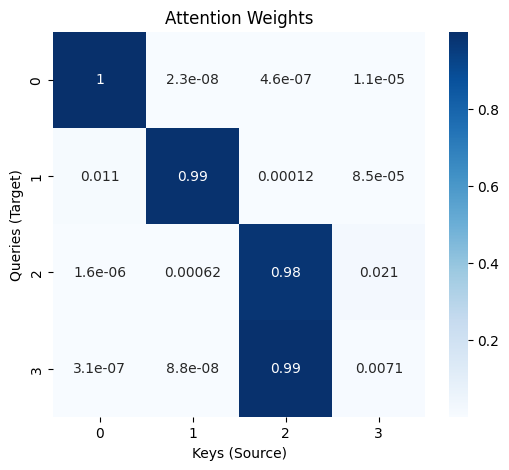

In [6]:
plt.figure(figsize=(6,5))
sns.heatmap(attention_weights[0].detach().numpy(), annot=True, cmap='Blues')
plt.xlabel("Keys (Source)")
plt.ylabel("Queries (Target)")
plt.title("Attention Weights")
plt.show()

## 5. Step 3: Weighted Sum (The Context)
$$ weights @ V $$
We multiply the probabilities by the Values.
If word 1 pays 90% attention to word 2, it will take 90% of word 2's Value vector.

In [7]:
output = attention_weights @ V

print(f"Output Shape: {output.shape}") # (1, 4, 8)
# This output is the "Contextualized" representation of the input words.

Output Shape: torch.Size([1, 4, 8])


## Summary: The Function
This is what PyTorch does internally.

In [8]:
def scaled_dot_product_attention(Q, K, V):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    weights = F.softmax(scores, dim=-1)
    output = torch.matmul(weights, V)
    return output, weights

# Verify
out, attn = scaled_dot_product_attention(Q, K, V)
print("Function match:", torch.allclose(out, output))

Function match: True
